# Introduction to Data Science 2025

# Week 6: Recap

## Exercise 1 | Linear regression with feature selection

Download the [TED Talks](https://www.kaggle.com/rounakbanik/ted-talks) dataset from Kaggle. Your task is to predict both the ratings and the number of views of a given TED talk. You should focus only on the <span style="font-weight: bold">ted_main</span> table.

1. Download the data, extract the following ratings from column <span style="font-weight: bold">ratings</span>: <span style="font-weight: bold">Funny</span>, <span style="font-weight: bold">Confusing</span>, <span style="font-weight: bold">Inspiring</span>. Store these values into respective columns so that they are easier to access. Next, extract the tags from column <span style="font-weight: bold">tags</span>. Count the number of occurrences of each tag and select the top-100 most common tags. Create a binary variable for each of these and include them in your data table, so that you can directly see whether a given tag (among the top-100 tags) is used in a given TED talk or not. The dataset you compose should have dimension (2550, 104), and comprise of the 'views' column, the three columns with counts of "Funny", "Confusing and "Inspiring" ratings, and 100 columns which one-hot encode the top-100 most common tag columns.


In [29]:
# Use this cell for your code
import pandas as pd
import ast
import os
import kagglehub


path = kagglehub.dataset_download("rounakbanik/ted-talks")

file_path = os.path.join(path, "ted_main.csv")
df = pd.read_csv(file_path)

def extract_rating(ratings_str, rating_name):
    ratings = ast.literal_eval(ratings_str)
    for r in ratings:
        if r["name"] == rating_name:
            return r["count"]
    return 0

df["Funny"] = df["ratings"].apply(lambda x: extract_rating(x, "Funny"))
df["Confusing"] = df["ratings"].apply(lambda x: extract_rating(x, "Confusing"))
df["Inspiring"] = df["ratings"].apply(lambda x: extract_rating(x, "Inspiring"))

df["tags"] = df["tags"].apply(ast.literal_eval)
all_tags = [tag for tags_list in df["tags"] for tag in tags_list]
top_100_tags = pd.Series(all_tags).value_counts().head(100).index

tags_df = pd.DataFrame({
    tag: df["tags"].apply(lambda x, t=tag: int(t in x))
    for tag in top_100_tags
})

final_df = pd.concat(
    [df[["views", "Funny", "Confusing", "Inspiring"]], tags_df],
    axis=1
)
print("Final shape:", final_df.shape)
final_df.head()





Final shape: (2550, 104)


,views,Funny,Confusing,Inspiring,technology,science,global issues,culture,TEDx,design,...,food,religion,family,peace,ecology,illness,demo,poetry,universe,social media
0,47227110,19645,242,24924,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3200520,544,62,413,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1636292,964,27,230,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1697550,59,32,1070,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12005869,1390,72,2893,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


2. Construct a linear regression model to predict the number of views based on the data in the <span style="font-weight: bold">ted_main</span> table, including the binary variables for the top-100 tags that you just created.

In [30]:
# Use this cell for your code
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = final_df.drop(columns=["views"])
y = final_df["views"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#results
coef_df = (
    pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": model.coef_
    })
    .sort_values(by="Coefficient", ascending=False)
)




3. Do the same for the <span style="font-weight: bold">Funny</span>, <span style="font-weight: bold">Confusing</span>, and <span style="font-weight: bold">Inspiring</span> ratings.

In [31]:
# Use this cell for your code
def train_linear_model(df, target_col, test_size=0.2, random_state=42):
    X = df.drop(columns=["views", target_col])
    y = df[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\n--- {target_col.upper()} MODEL ---")
    print(f"R² score: {r2:.4f}")
    print(f"RMSE: {rmse:.2f}")
    
    coef_df = (
        pd.DataFrame({
            "Feature": X.columns,
            "Coefficient": model.coef_
        })
        .sort_values(by="Coefficient", ascending=False)
    )
    print("\nTop 5 positive predictors:")
    print(coef_df.head(5))
    print("\nTop 5 negative predictors:")
    print(coef_df.tail(5))
    print("--------------------------------------------")
    
    return model, coef_df





4. You will probably notice that most of the tags are not useful in predicting the views and the ratings. You should use some kind of variable selection to prune the set of tags that are included in the model. You can use for example classical p-values or more modern [LASSO](https://en.wikipedia.org/wiki/Lasso_(statistics)) techniques. Which tags are the best predictors of each of the response variables?

In [32]:
# Use this cell for your code
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


def lasso_feature_selection(df, target_col):
    X = df.drop(columns=["views", "Funny", "Confusing", "Inspiring"])
    y = df[target_col]
    
    model = make_pipeline(StandardScaler(), LassoCV(cv=10, random_state=42))
    model.fit(X, y)
    coefs = model.named_steps['lassocv'].coef_
    
    #dataframe
    coef_df = pd.DataFrame({
        "Feature": X.columns,
        "Coefficient": coefs
    }).sort_values(by="Coefficient", ascending=False)
    
    selected = coef_df[coef_df["Coefficient"] != 0]
    
    print(f"\n--- {target_col.upper()} | Selected features: {len(selected)} ---")
    print("\nTop 10 positive predictors:")
    print(selected.head(10))
    print("\nTop 10 negative predictors:")
    print(selected.tail(10))
    
    return model, selected




5. Produce summaries of your results. Could you recommend good tags – or tags to avoid! – for speakers targeting plenty of views and/or certain ratings?

Yeah!, the next summary will give a creator an idea of which tags to use and which ones to avoid

In [33]:
print("\nTop 10 positive predictors for Views:")
print(coef_df.head(10))

print("\nTop 10 negative predictors for Views:")
print(coef_df.tail(10))


#
print('For each: Inspiring, Funny and Confusing')
model_inspiring, coef_inspiring = train_linear_model(final_df, "Inspiring")
model_confusing, coef_confusing = train_linear_model(final_df, "Confusing")
model_funny, coef_funny = train_linear_model(final_df, "Funny")



#
print('Filtering on features')
lasso_views, selected_views = lasso_feature_selection(final_df, "views")
lasso_inspiring, selected_inspiring = lasso_feature_selection(final_df, "Inspiring")
lasso_confusing, selected_confusing = lasso_feature_selection(final_df, "Confusing")
lasso_funny, selected_funny = lasso_feature_selection(final_df, "Funny")


Top 10 positive predictors for Views:
              Feature    Coefficient
99               demo  968720.159289
56        photography  417399.096420
83         motivation  398177.104994
101          universe  390108.604830
37         psychology  388733.234375
87             robots  371731.181496
95             family  277569.586454
55   medical research  256423.666077
68          potential  255363.671347
25              brain  237855.400988

Top 10 negative predictors for Views:
          Feature    Coefficient
5   global issues -250775.208465
66        physics -266031.587363
31       children -276667.060394
67          green -327026.892762
18     creativity -340956.705602
69      happiness -413291.442659
94       religion -419640.154903
89        poverty -436108.446706
46           life -477698.252069
81     philosophy -541966.600677
For each: Inspiring, Funny and Confusing

--- INSPIRING MODEL ---
R² score: 0.2003
RMSE: 856.92

Top 5 positive predictors:
          Feature  Coefficie

**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

## Exercise 2 | Symbol classification (part 2)

Note that it is strongly recommended to use Python in this exercise. However, if you can find a suitable AutoML implementation for your favorite language (e.g [here](http://h2o-release.s3.amazonaws.com/h2o/master/3888/docs-website/h2o-docs/automl.html) seems to be one for R) then you are free to use that language as well.

Use the preprocessed data from week 3 (you can also produce them using the example solutions of week 3).

1. This time train a *random forest classifier* on the data. A random forest is a collection of *decision trees*, which makes it an *ensemble* of classifiers. Each tree uses a random subset of the features to make its prediction. Without tuning any parameters, how is the accuracy?

In [38]:
# Use this cell for your code
import pandas as pd 

# Ruta al archivo CSV
csv_path = r"C:\\Users\\alexr\\Downloads\\HASYv2\\hasy-data-labels.csv"

# Leer el CSV
labels = pd.read_csv(csv_path)

print(labels.shape)
print(labels.head())
subset = labels[(labels["symbol_id"] >= 70) & (labels["symbol_id"] <= 79)]

print(subset.shape)
print(subset.head())

import numpy as np
from PIL import Image
import os

# Carpeta donde están las imágenes
base_dir = r"C:\\Users\\alexr\\Downloads\\HASYv2"

X = []
y = []

for _, row in subset.iterrows():
    
    img_path = os.path.join(base_dir, row["path"])
    
    img = Image.open(img_path).convert("L").resize((32, 32))
        
    img_array = np.array(img)
    
    img_flat = img_array.flatten()
    
    X.append(img_flat)
    y.append(row["symbol_id"])


X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  
print("y shape:", y.shape)  


(168233, 4)
                     path  symbol_id latex  user_id
0  hasy-data/v2-00000.png         31     A       50
1  hasy-data/v2-00001.png         31     A       10
2  hasy-data/v2-00002.png         31     A       43
3  hasy-data/v2-00003.png         31     A       43
4  hasy-data/v2-00004.png         31     A     4435
(1020, 4)
                       path  symbol_id latex  user_id
345  hasy-data/v2-00345.png         70     0       10
346  hasy-data/v2-00346.png         70     0       31
347  hasy-data/v2-00347.png         70     0       10
348  hasy-data/v2-00348.png         70     0       10
349  hasy-data/v2-00349.png         70     0       10
X shape: (1020, 1024)
y shape: (1020,)


2. The amount of trees to use as a part of the random forest is an example of a hyperparameter, because it is a parameter that is set prior to the learning process. In contrast, a parameter is a value in the model that is learned from the data. Train 20 classifiers, with varying amounts of decision trees starting from 10 up until 200, and plot the test accuracy as a function of the amount of classifiers. Does the accuracy keep increasing? Is more better?

Trees:  10 | Test Accuracy: 0.6716
Trees:  20 | Test Accuracy: 0.7745
Trees:  30 | Test Accuracy: 0.7500
Trees:  40 | Test Accuracy: 0.7990
Trees:  50 | Test Accuracy: 0.7794
Trees:  60 | Test Accuracy: 0.7941
Trees:  70 | Test Accuracy: 0.8039
Trees:  80 | Test Accuracy: 0.7990
Trees:  90 | Test Accuracy: 0.7990
Trees: 100 | Test Accuracy: 0.8088
Trees: 110 | Test Accuracy: 0.8039
Trees: 120 | Test Accuracy: 0.8137
Trees: 130 | Test Accuracy: 0.7892
Trees: 140 | Test Accuracy: 0.8039
Trees: 150 | Test Accuracy: 0.8137
Trees: 160 | Test Accuracy: 0.8088
Trees: 170 | Test Accuracy: 0.8137
Trees: 180 | Test Accuracy: 0.8137
Trees: 190 | Test Accuracy: 0.8088
Trees: 200 | Test Accuracy: 0.8186


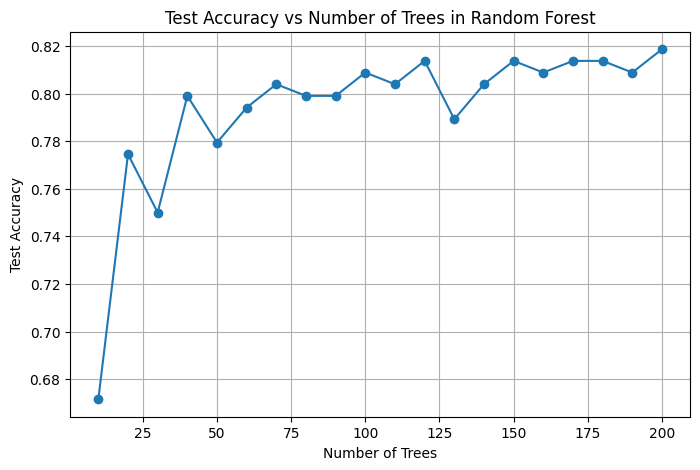

In [40]:
# Use this cell for your code
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Split data into train/test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Range of tree counts
n_trees = np.arange(10, 201, 10)  # 10, 20, 30, ..., 200
accuracies = []

# Train 20 models with different number of trees
for n in n_trees:
    model = RandomForestClassifier(
        n_estimators=n,
        random_state=42,
        n_jobs=-1  # use all cores for speed
    )
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Trees: {n:3d} | Test Accuracy: {acc:.4f}")

# Plot accuracy vs number of trees
plt.figure(figsize=(8, 5))
plt.plot(n_trees, accuracies, marker="o")
plt.title("Test Accuracy vs Number of Trees in Random Forest")
plt.xlabel("Number of Trees")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


3. If we had picked the amount of decision trees by taking the value with the best test accuracy from the last plot, we would have *overfit* our hyperparameters to the test data. Can you see why it is a mistake to tune hyperparameters of your model by using the test data?

Tuning hyperparameters using the test data is a mistake because the test set is meant to simulate completely unseen data it represents the final, unbiased measure of a model’s generalization ability. If you choose hyperparameters based on test performance, you’re indirectly training the model to perform well on that specific test set, leaking information from it into the training process. This leads to overfitting the hyperparameters to the test data: the model appears to perform better than it truly would on new, unseen data. To avoid this, hyperparameter tuning should be done using a separate validation set or through cross-validation, keeping the test data untouched until the very end.

4. Reshuffle and resplit the data so that it is divided in 3 parts: training (80%), validation (10%) and test (10%). Repeatedly train a model of your choosing (e.g random forest) on the training data, and evaluate it’s performance on the validation set, while tuning the hyperparameters so that the accuracy on the validation set increases. Then, finally evaluate the performance of your model on the test data. What can you say in terms of the generalization of your model?

In [43]:
# Use this cell for your code
from sklearn.model_selection import train_test_split

# First split off the test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Split the remaining 90% into training (80%) and validation (10%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=1/9, random_state=42, stratify=y_temp
)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Training shape: (816, 1024)
Validation shape: (102, 1024)
Test shape: (102, 1024)


Best validation accuracy: 0.8725490196078431
Best hyperparameters: {'n_estimators': 50, 'max_depth': None}


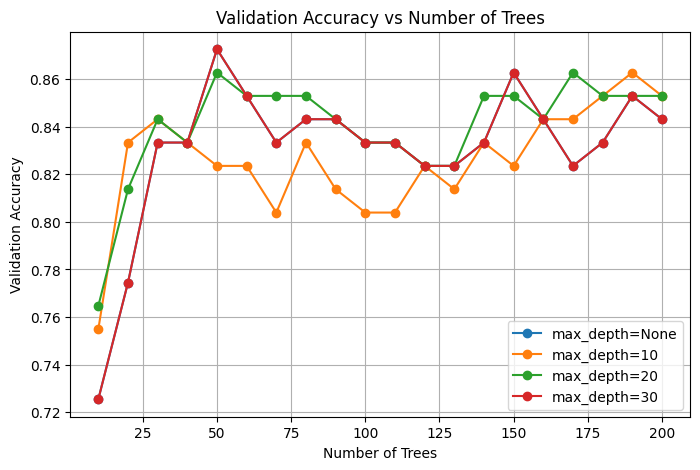

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

n_trees = np.arange(10, 201, 10)
max_depths = [None, 10, 20, 30]  # Example of varying max depth
best_val_acc = 0
best_params = {}
val_accuracies = []

for depth in max_depths:
    acc_list = []
    for n in n_trees:
        model = RandomForestClassifier(
            n_estimators=n,
            max_depth=depth,
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        acc = accuracy_score(y_val, y_val_pred)
        acc_list.append(acc)
        
        if acc > best_val_acc:
            best_val_acc = acc
            best_params = {"n_estimators": n, "max_depth": depth}
    
    val_accuracies.append(acc_list)

print("Best validation accuracy:", best_val_acc)
print("Best hyperparameters:", best_params)

# Plot validation accuracy for each max_depth
plt.figure(figsize=(8,5))
for i, depth in enumerate(max_depths):
    plt.plot(n_trees, val_accuracies[i], marker='o', label=f"max_depth={depth}")
plt.xlabel("Number of Trees")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Number of Trees")
plt.legend()
plt.grid(True)
plt.show()


In [45]:
# Train final model on training + validation data
X_train_val = np.vstack([X_train, X_val])
y_train_val = np.hstack([y_train, y_val])

final_model = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_val, y_train_val)

y_test_pred = final_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)

print("Test accuracy:", test_acc)


Test accuracy: 0.8529411764705882


**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**

## Exercise 3 | TPOT

The process of picking a suitable model, evaluating its performance and tuning the hyperparameters is very time consuming. A new idea in machine learning is the concept of automating this by using an optimization algorithm to find the best model in the space of models and their hyperparameters. Have a look at [TPOT](https://github.com/EpistasisLab/tpot), an automated ML solution that finds a good model and a good set of hyperparameters automatically. Try it on this data, it should outperform simple models like the ones we tried easily. Note that running the algorithm might take a while, depending on the strength of your computer. 

*Note*: In case it is running for too long, try checking if the parameters you are using when calling TPOT are reasonable, i.e. try reducing number of ‘generations’ or ‘population_size’. TPOT uses cross-validation internally, so we don’t need our own validation set.

In [48]:
# Use this cell for your code
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split

# Split into training and test set (TPOT uses CV internally)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create TPOT classifier
tpot = TPOTClassifier(
    generations=5,       # Number of iterations of the genetic algorithm
    population_size=20,  # Number of pipelines to evaluate per generation
    verbosity=2,         # Show progress
    random_state=42,
    n_jobs=-1            # Use all CPU cores
)

# Fit TPOT to training data
tpot.fit(X_train, y_train)

# Evaluate on test set
print("Test accuracy:", tpot.score(X_test, y_test))

# Export the best pipeline as Python code
tpot.export("tpot_best_pipeline.py")


ImportError: cannot import name 'get_tags' from 'sklearn.utils._tags' (c:\Users\alexr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py)

**Remember to submit your code on the MOOC platform. You can return this Jupyter notebook (.ipynb) or .py, .R, etc depending on your programming preferences.**